# Melanoma Skin Cancer Detection Model

*Daniel Szelepcsenyi*
<br>
*July 31st, 2024*
<br>
*Kyoto University*

## Introduction

Melanoma skin cancer is a type of cancer that originates from melanocytes, cells that are found naturally in the skin. It can spread rapidly and aggressively to other parts of the body if it is not detected early. On the skin, melanomas often appear as moles that are either new or changing. Because of the danger involved with skin cancer, early detection and diagnosis is crucial as earlier identification can lead to a much higher likelihood of successful treatment. For this reason, patients will often have examinations undergone for their skin moles to determine whether they are benign (non-cancerous) or malignant (cancerous, melonoma). Early diagnosis of melanoma skin cancer can significantly improve patient outcomes. Analysis shows that the 5-year survival rate for melonoma is over 98% for localized, early cases, but is 64% for regionally-spread melanoma and only 23% for melanoma that has already spread to distant sites [[1](https://www.curemelanoma.org/about-melanoma/melanoma-staging/melanoma-survival-rates)]. 

The traditional methods of detection involve visual examinations and biopsy procedures by dermatologists. For example, a common instruction for cancerous melanoma detection is known as the "ABCDEs of Melanoma": **asymmetry**, an irregular **border**, varying **colors**, a **diameter** of above 6 milimtetres, and the mole **evolving** by changing over time [[2](https://www.aad.org/public/diseases/skin-cancer/find/at-risk/abcdes)]. However, traditional diagnostic methods can take a lot of time and resources from doctors, as well as incorporating human error into the detection process which is often caused by subjective diagnoses of a mole. Due to these limitations, there is a growing need for automated systems that can be used for early detection of melonoma. 

One technique that can be applied as an advanced diagnostic tool is a Convolutional Neural Network (CNN). CNNs are highly effective in complex image recognition and classification tasks. They learn and adapt to features in images such as edges and textures that humans may not be able to even recognize or interpret correctly. For this reason, they can be a very effective tool for distuingishing between benign and malignant moles to detect the presence of melanoma skin cancer.

This report aims to present an example of a CNN-based approach being implemented in a model that can detect whether a mole is benign or malignant based on an image provided. This will demonstrate the techniques that can be used for a CNN being trained to classify moles and the ways in which models can be evaluated and improved for the future.


### Convolutional Neural Network
Convolutional Neural Networks (CNNs) are the backbone of modern computer vision tasks due to their ability to extract hierarchical features from images. CNNs automatically learn features from raw image data without needing manual feature extraction such as that in most supervised learning applications, enabling them to adapt to complex patterns and strcutues effectively.

The CNN model used in this report for melanoma detection is designed with the following architecture:
* Convolutional Layers: The model uses three convolutional layers that are followed by a ReLu activation function and max-pooling operation. The convolutional layers are able to learn spatial hierarchies of figures when convolution is applied along with a kernel.
* Max Pooling: Max pooling is applied after each convolution layer, reducing the spatial dimensions of the feature maps to improve efficiency and reduce overfitting while maintaining the most significant details and parameters.
* Fully Connected Layers: After the convolutional layers and max pooling, the output is flattened and passed through two convolutional layers: first to a layer with 128 neurons and then to a layer with only 1 neuron. A dropout layer is also included to help avoid overfitting. This final layer produces an output of a single score that represents the probability of the mole being malignant. 


## Code Implementation
#### Dataset Preparation
The dataset that is used for this analysis of the melanoma skin cancer moles contains 10,000 images and can be found here: [[Melanoma Skin Cancer Dataset of 10000 Images - Kaggle](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images?resource=download)].

To begin, the necessary libraries are installed and imported and then the dataset is imported and preprocessed.

In [1]:
#!pip install chainer
#!pip install opencv-python
#!pip install tqdm
#!pip install cupy
#!pip install chainer cupy
#!pip install seaborn

In [ ]:
import os
import numpy as np
import chainer
import chainer
from chainer.backends import cuda
import chainer.functions as F
import chainer.links as L
import glob as gb
import matplotlib.pyplot as plt
import random
import cupy
from tqdm import tqdm
import gc

In [3]:
# Configure environment for GPU
gpu_device = 0
cuda.get_device_from_id(gpu_device).use()
xp = cuda.cupy  # Use CuPy for GPU operations

In [4]:
train_dir = "./melanoma_cancer_dataset/train"
test_dir = "./melanoma_cancer_dataset/test"

In [5]:
num_benign = len(os.listdir(train_dir + "/benign"))
num_malignant = len(os.listdir(train_dir + "/malignant"))
num_test = len(os.listdir(test_dir + "/benign")) + len(os.listdir(test_dir + "/malignant"))
print("Number of training images: ", num_benign + num_malignant)
print("Number of benign training images: ", num_benign)
print("Number of malignant training images: ", num_malignant)
print("\nNumber of test images: ", num_test)

Number of training images:  9605
Number of benign training images:  5000
Number of malignant training images:  4605

Number of test images:  1000


In [6]:
# Define the training dataset
X_train = []  # Images
y_train = []  # Labels
class_ = {'benign': 0, 'malignant': 1}

for folder in os.listdir(train_dir):
    data = gb.glob(pathname=str(train_dir + '/' + folder + '/*.jpg'))
    for file in data:
        images = plt.imread(file)
        images = np.array(images, dtype=np.float32) / 255.0  # Convert to float32 and normalize
        images = np.moveaxis(images, -1, 0)  # Move channels to first dimension
        X_train.append(images)
        y_train.append(class_[folder])

train = list(zip(X_train, y_train))

# Define the testing dataset
X_test = []  # Images
y_test = []  # Labels

for folder in os.listdir(test_dir):
    data = gb.glob(pathname=str(test_dir + '/' + folder + '/*.jpg'))
    for file in data:
        images = plt.imread(file)
        images = np.array(images, dtype=np.float32) / 255.0  # Convert to float32 and normalize
        images = np.moveaxis(images, -1, 0)  # Move channels to first dimension
        X_test.append(images)
        y_test.append(class_[folder])

test = list(zip(X_test, y_test))

# Shuffle the datasets for random mix of benign and malignant skin images.
random.shuffle(train)
random.shuffle(test)

For visualization of the dataset's images, the following code presents the images along with their labels (benign or malignant).

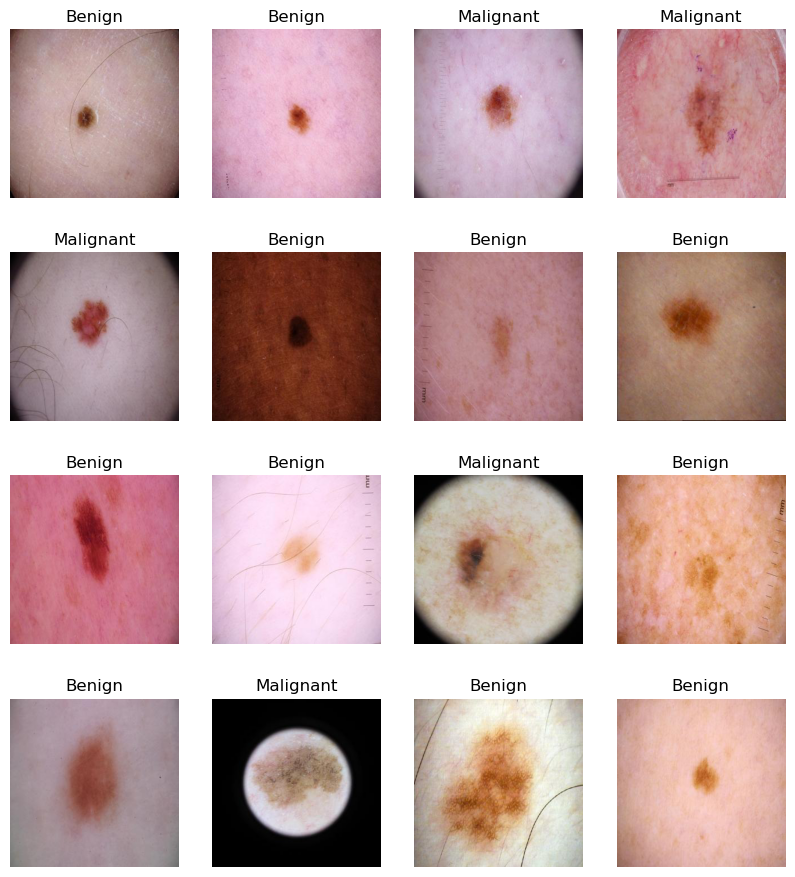

In [7]:
def display_images(images_with_labels, nb_images=16, nb_images_per_row=4):
    plt.figure(figsize=(10, 14))
    for i, (image, label) in enumerate(images_with_labels[:nb_images]):
        image = np.moveaxis(image, 0, -1)  # Move channels back to last dimension for display
        plt.subplot(nb_images // nb_images_per_row + 1, nb_images_per_row, i + 1)
        plt.imshow(image)
        plt.title('Benign' if label == 0 else 'Malignant')
        plt.axis('off')
    plt.show()

display_images(train, nb_images=16, nb_images_per_row=4)

#### Model Architecture and Training
We will define a Convolutional Neural Network (CNN) to train based on the skin images. For this, we use convolution layers followed by fully connected layers. The architecture also employs max pooling, and rectified linear units for highly accurate and efficient analysis. 

Then, the CNN will be trained using the training dataset. In this process, the optimizer is defined (the adam optimizer is used here), and gradient clipping is configured to prevent overfitting. Training is done in batches of images to improve the efficiency and coverage of the speed, and multiple epochs are used for deeper results.

In [8]:
class CancerRecognitionModel(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv_layer_1 = L.Convolution2D(3, 32, ksize=3, pad=1)
            self.conv_layer_2 = L.Convolution2D(32, 64, ksize=3, pad=1)
            self.conv_layer_3 = L.Convolution2D(64, 128, ksize=3, pad=1)
            self.fc_layer_1 = L.Linear(None, 128)
            self.fc_layer_2 = L.Linear(128, 1)

    def __call__(self, images):
        scores = self.compute_scores(images)
        return F.sigmoid(scores)

    def compute_scores(self, images):
        minibatch_size = images.shape[0]

        h = F.relu(self.conv_layer_1(images))
        h = F.max_pooling_2d(h, ksize=2)
        h = F.relu(self.conv_layer_2(h))
        h = F.max_pooling_2d(h, ksize=2)
        h = F.relu(self.conv_layer_3(h))
        h = F.max_pooling_2d(h, ksize=2)

        flattened_output = F.reshape(h, (minibatch_size, -1))

        h = F.dropout(F.relu(self.fc_layer_1(flattened_output)), ratio=0.5)
        h = self.fc_layer_2(h)
        return h

cancermodel = CancerRecognitionModel()  # Create a randomly initialized model
cancermodel.to_gpu(gpu_device)  # Move the model to the GPU
optimizer = chainer.optimizers.Adam()
optimizer.setup(cancermodel)
optimizer.add_hook(chainer.optimizer.GradientClipping(1))  # Clip the gradient

In [9]:
# Pack images in batch arrays for gradient descent
def pack_images_in_batch(dataset):
    batch_image = xp.vstack([img[np.newaxis, ...] for img, cls in dataset])
    batch_class = xp.array([cls for img, cls in dataset], dtype=xp.int32).reshape((-1, 1))
    return batch_image, batch_class

In [10]:
# Train data
minibatch_size = 64
number_of_epochs_to_train = 10

for num_epoch in range(number_of_epochs_to_train):
    cursor = 0
    losses = []
    with tqdm(total=len(train), desc=f"Epoch {num_epoch + 1}/{number_of_epochs_to_train}") as pbar:
        while cursor < len(train):
            batch_image, batch_class = pack_images_in_batch(train[cursor:cursor + minibatch_size])
            cursor += minibatch_size

            cancermodel.cleargrads()
            predictions = cancermodel.compute_scores(batch_image)
            loss = F.sigmoid_cross_entropy(predictions, batch_class)

            losses.append(float(loss.array))

            loss.backward()
            optimizer.update()

            # Free up memory
            del batch_image, batch_class, predictions, loss
            cuda.memory_pool.free_all_blocks()
            cupy.get_default_memory_pool().free_all_blocks()
            gc.collect()

            pbar.update(minibatch_size)

    print(f"Epoch {num_epoch + 1} Loss: {np.mean(losses)}")

Epoch 1/10: 9664it [03:36, 44.74it/s]                                                                                  


Epoch 1 Loss: 0.7598212585840004


Epoch 2/10: 9664it [04:43, 34.12it/s]                                                                                  


Epoch 2 Loss: 0.3167821454093946


Epoch 3/10: 9664it [04:38, 34.67it/s]                                                                                  


Epoch 3 Loss: 0.2882725762709087


Epoch 4/10: 9664it [04:29, 35.86it/s]                                                                                  


Epoch 4 Loss: 0.26560384316357555


Epoch 5/10: 9664it [04:42, 34.22it/s]                                                                                  


Epoch 5 Loss: 0.2431287503992485


Epoch 6/10: 9664it [04:51, 33.15it/s]                                                                                  


Epoch 6 Loss: 0.23048627953853038


Epoch 7/10: 9664it [05:33, 29.00it/s]                                                                                  


Epoch 7 Loss: 0.22873692281100133


Epoch 8/10: 9664it [04:40, 34.44it/s]                                                                                  


Epoch 8 Loss: 0.2151512005119677


Epoch 9/10: 9664it [02:22, 67.70it/s]                                                                                  


Epoch 9 Loss: 0.1988452129830785


Epoch 10/10: 9664it [02:26, 66.16it/s]                                                                                 

Epoch 10 Loss: 0.1888365820882879


After training the model, we evaluate its performance by calculating its accuracy on the test dataset.

Accuracy: 91.10%
Precision: 0.97
Recall: 0.85
F1 Score: 0.91


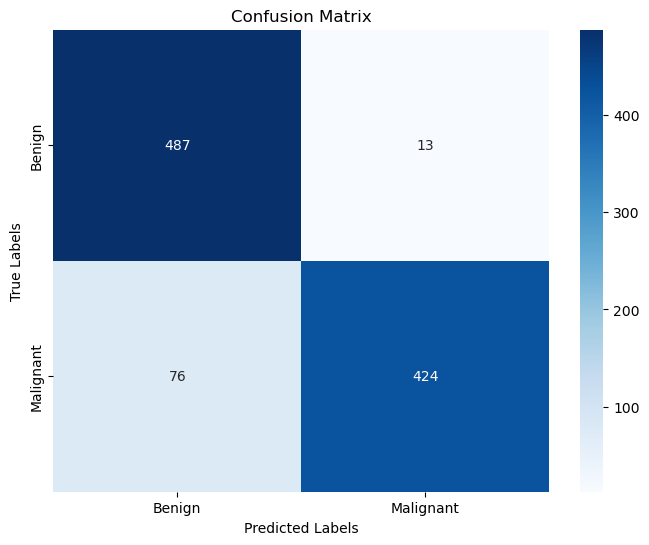

In [11]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model_statistics(model, dataset):
    y_true = []
    y_pred = []
    
    with chainer.using_config('train', False): 
        for i in range(len(dataset)):
            img = dataset[i][0][None, ...]  # Add batch dimension
            img = xp.asarray(img)  # Convert numpy array to cupy array
            label = dataset[i][1]
            pred = model(img).array
            y_true.append(label)
            y_pred.append(int(np.round(pred[0, 0])))

    # Calculate metrics
    accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model_statistics(cancermodel, test)

This version of the model has an accuracy of 91%. 

The next segment of code displays some of the skin images in the test set along with the model's predictions and the belief score to better visualize its predictions.

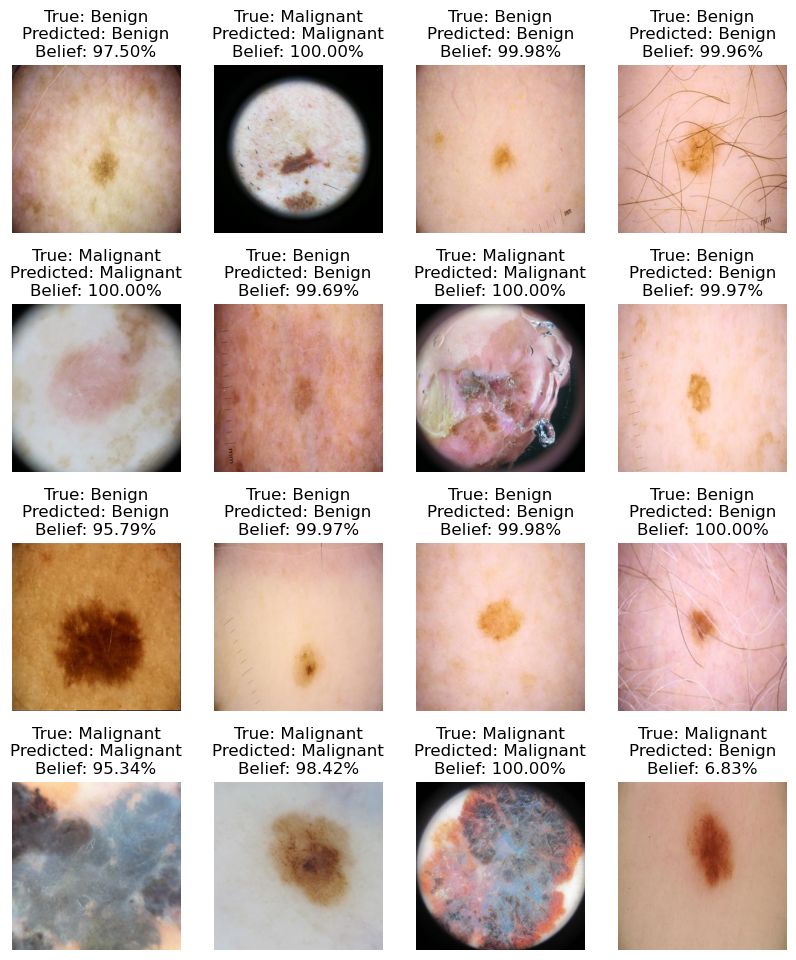

In [12]:
def display_predictions_with_beliefs(model, dataset, nb_images=16, nb_images_per_row=4):
    images_with_predictions = []
    beliefs = []
    predictions = []

    with chainer.using_config('train', False):  # Disable training mode for evaluation
        for i in range(nb_images):
            img, true_label = dataset[i]
            img = xp.asarray(img[None, ...]) 
            belief = model(img).array[0, 0]  # Get the belief score from the model
            pred_label = np.round(belief)  # Predict the label

            if true_label == 0:
                belief_percentage = (1 - belief) * 100 
            else:
                belief_percentage = belief * 100

            images_with_predictions.append((img[0].get(), true_label))  # Convert back to NumPy array for displaying
            beliefs.append(belief_percentage)
            predictions.append(int(pred_label))

    # Display images with predictions and belief scores
    plt.figure(figsize=(10, 15))
    for i, (image, true_label) in enumerate(images_with_predictions):
        image = np.moveaxis(image, 0, -1)  # Move channels back to last dimension for display
        plt.subplot(nb_images // nb_images_per_row + 1, nb_images_per_row, i + 1)
        plt.imshow(image)
        plt.title(f'True: {"Benign" if true_label == 0 else "Malignant"}\n'
                  f'Predicted: {"Benign" if predictions[i] == 0 else "Malignant"}\n'
                  f'Belief: {beliefs[i]:.2f}%')
        plt.axis('off')
    plt.show()

display_predictions_with_beliefs(cancermodel, test, nb_images=16, nb_images_per_row=4)


## Summary
#### Results and Key Findings
The CNN model demonstrated significant potential in detecting melanoma with an accuracy of **91.4%**. This result showcases the effectiveness of deep learning models as advanced diagnostic tools to detect the difference between benign and malignant models. The model is able to learn complex features from the images to make reliable predictions in ways that humans may not be able to replicate or understand. However, this model is still prone to error as shown by the 9% of cases that are incorrectly predicted.

There were several optimizations for computational efficiency due to the limitations of the scope of this report and this program as well as the time required to train the model. It may be possible to continue to improve the accuracy of the model by training it through more epochs or adding additional convolutional and/or fully connected layers.

#### Conclusion

This CNN-based melanoma skin cancer detection model is a simple yet significant advancement in the use of artificial intelligence for medical diagnostics. While human intervention from trained doctors to identify melanoma skin cancer is still generally preferred, an autonomous diagnostic tool will allow for quick and efficient screening. Ongoing research and development in deep learning and computer vision holds promise for even more robust diagnostic tools in the future. 

Ideally, a combination of these advanced diagnostic tools as well as human input from doctors and specialists will allow for very accurate and accessible diagnostic measures. In the case of skin cancer, many more individuals will be able to diagnose their melanoma early and undergo the necessary proactive treatment to prevent the disease from spreading and ultimately save their life.


### Resources
1. https://www.curemelanoma.org/about-melanoma/melanoma-staging/melanoma-survival-rates
2. https://www.aad.org/public/diseases/skin-cancer/find/at-risk/abcdes
3. https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images?resource=download